In [1]:
!pip install z3-solver

In [2]:
from z3 import *
from math import floor

In [3]:
import sys 
sys.path.append('../../')
from utils.utils import * 

In [4]:
def pack_rectangles(timeout, max_width, lowerbound, H_UB, number_rectangles, width,height,rotation,symmetry, verbose = False):

    #start_time = time.time()
   
    s = Optimize()
    s.set("timeout", timeout * 1000)

    circuits_x = [Int(f"x_{i}") for i in range(number_rectangles)]
    circuits_y = [Int(f"y_{i}") for i in range(number_rectangles)]
    circuits_w,circuits_h=width,height
    
    #computing upperbound
    xx=circuits_x.copy()
    yy=circuits_y.copy()  
    W =max_width
    upperbound = H_UB
    
    Rectangle_height = Int('Rectangle_height')
    s.add(Rectangle_height <= upperbound)
    s.add(Rectangle_height >= lowerbound)
    R = [Bool('R%s' % i) for i in range(number_rectangles)]

    H = lowerbound
        
    if not(rotation):
        non_overlap = [Or( 
                        circuits_x[i] + circuits_w[i] <= circuits_x[j],
                        circuits_x[i] >= circuits_x[j] + circuits_w[j],
                        circuits_y[i] + circuits_h[i] <= circuits_y[j],
                        circuits_y[i] >= circuits_y[j] + circuits_h[j]
                        ) for i in range(number_rectangles-1) for j in range(i+1, number_rectangles)]

        in_limits = [And(circuits_x[i] + circuits_w[i] <= max_width,
                    circuits_y[i] + circuits_h[i] <= Rectangle_height, 
                    circuits_x[i] >= 0, 
                    circuits_y[i] >= 0) for i in range(number_rectangles)]

        #implied constraints
        for i in range(number_rectangles):
            for j in range(number_rectangles):
                if i != j:
                    s.add(Implies(circuits_w[i] + circuits_w[j] > W,And(circuits_x[i]+circuits_w[i]>circuits_x[j],circuits_x[j]+circuits_w[j]>circuits_x[i])))
                    s.add(Implies(circuits_h[i] + circuits_h[j] > H,And(circuits_y[i]+circuits_h[i]>circuits_y[j],circuits_y[j]+circuits_h[j]>circuits_y[i])))

        #symmetry breaking constraint          
        if symmetry:
                areas = np.array(width) * np.array(height)
                i_max = np.argmax(areas) # index of the circuit with the biggest area
                bottom_left_x = [circuits_x[i_max] <= floor((max_width - width[i_max]) / 2  )]
                bottom_left_y = [circuits_y[i_max] <= floor((lowerbound - height[i_max]) / 2 )]
                s.add(bottom_left_x + bottom_left_y)

        s.add(non_overlap + in_limits)

    else:
        # constraint for non overlapping
        for i in range(number_rectangles):
            for j in range(number_rectangles):
                if i != j:
                    s.add(Or(
                             And(circuits_x[i] + height[i] <= circuits_x[j], R[i]),
                             And(circuits_x[i] + width[i] <= circuits_x[j], Not(R[i])),
                             And(circuits_x[j] + height[j] <=circuits_x[i], R[j]),
                             And(circuits_x[j] + width[j] <= circuits_x[i], Not(R[j])),
                             And(circuits_y[i] + width[i] <= circuits_y[j], R[i]),
                             And(circuits_y[i] + height[i] <= circuits_y[j], Not(R[i])),
                             And(circuits_y[j] + width[j] <= circuits_y[i], R[j]),     
                             And(circuits_y[j] + height[j] <= circuits_y[i], Not(R[j])),


                             ))

        #respecting the maximum boundaries on the x and y axsis 
        s.add([circuits_x[i] >= 0 for i in range(number_rectangles)])
        s.add([Or(Not(R[i]), circuits_x[i] + height[i] - 1 < max_width) for i in range(number_rectangles)])
        s.add([Or(R[i], circuits_x[i] + width[i] - 1 < max_width) for i in range(number_rectangles)])

        s.add([circuits_y[i] >= 0 for i in range(number_rectangles)])
        s.add([Or(R[i], circuits_y[i] + height[i] - 1 < Rectangle_height) for i in range(number_rectangles)])
        s.add([Or(Not(R[i]), circuits_y[i] + width[i] - 1 < Rectangle_height) for i in range(number_rectangles)])
        
        
        
        if symmetry:
                areas = np.array(width) * np.array(height)
                i_max = np.argmax(areas) # index of the circuit with the biggest area
                bottom_left_x = [circuits_x[i_max] <= floor((max_width - width[i_max]) / 2  )]
                bottom_left_y = [circuits_y[i_max] <= floor((lowerbound - height[i_max]) / 2 )]
                s.add(Not(R[i_max]))
                s.add(bottom_left_x + bottom_left_y)
                

                #not rotating squares
                squares_no_rotation = [ Implies(width[i] == height[i], Not(R[i])) for i in range(number_rectangles)]
                s.add(squares_no_rotation)

    s.minimize(Rectangle_height)

    if not(s.check() == sat):
        if verbose:
            print('UNSAT')
        return True,-1,-1,301,None

    
    if verbose:
        print(f'Solved in time:{s.statistics().time} s')
    
    model = s.model()
    
    x = [model.__getitem__(i).as_long() for i in circuits_x]
    y = [model.__getitem__(i).as_long() for i in circuits_y]
    time = s.statistics().time
    rot = [model.__getitem__(i) for i in R]
    
    return False, x, y, time,rot

  0%|          | 0/40 [00:00<?, ?it/s]

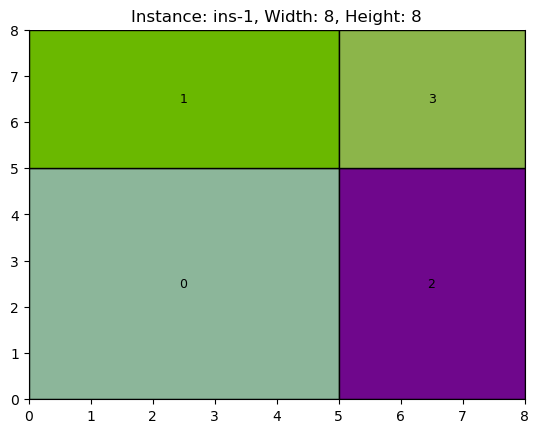

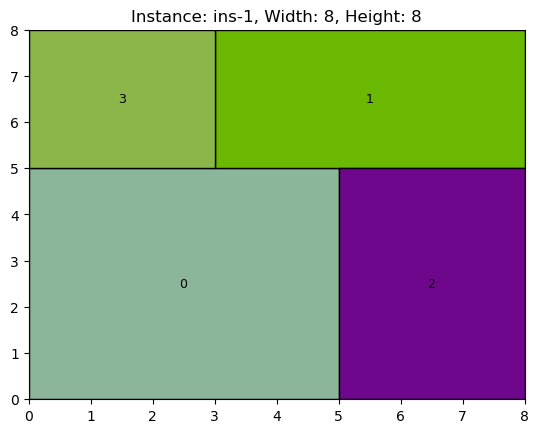

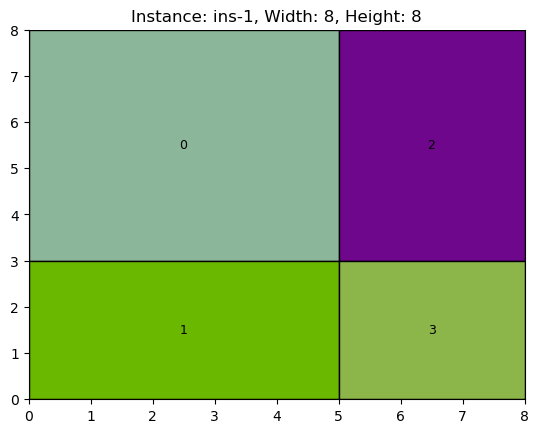

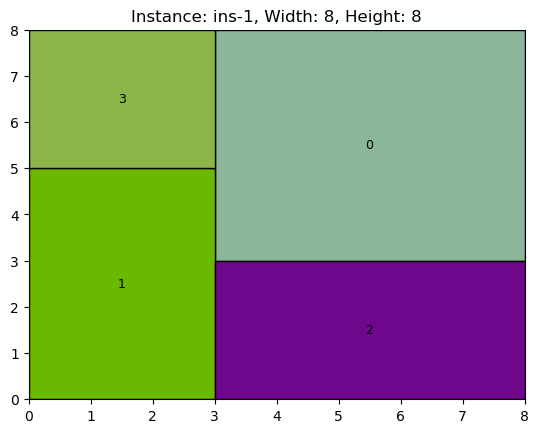

  2%|▎         | 1/40 [00:02<01:24,  2.18s/it]

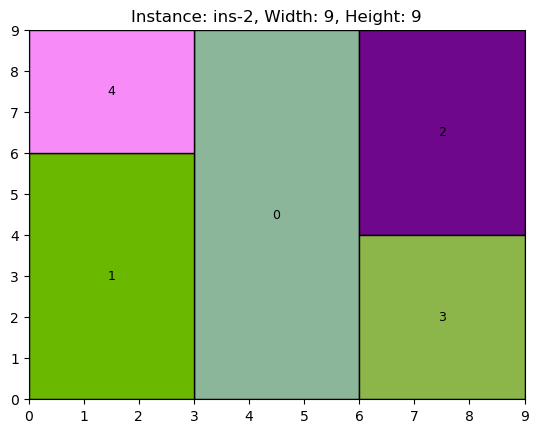

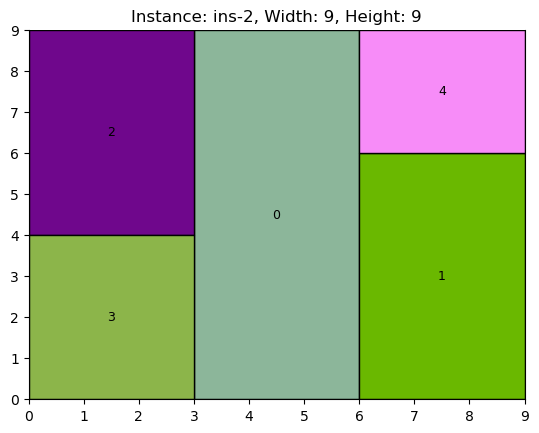

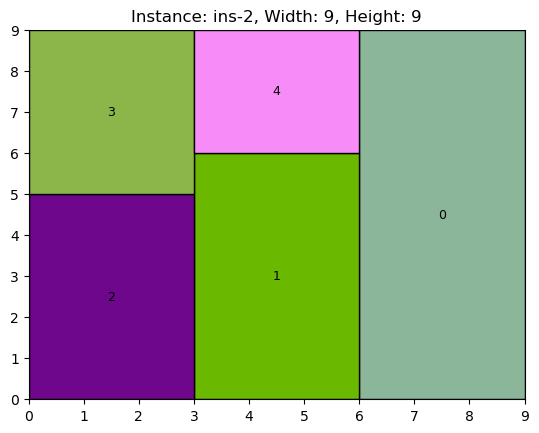

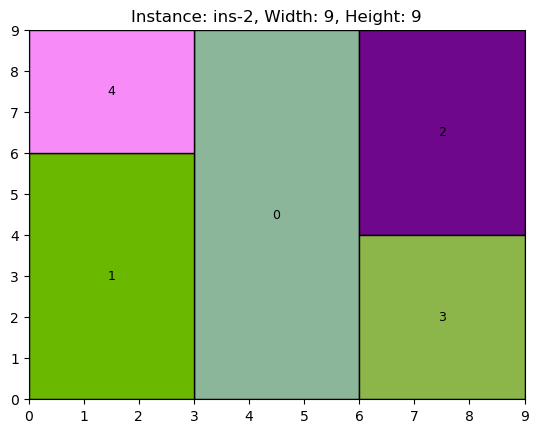

  5%|▌         | 2/40 [00:04<01:19,  2.10s/it]

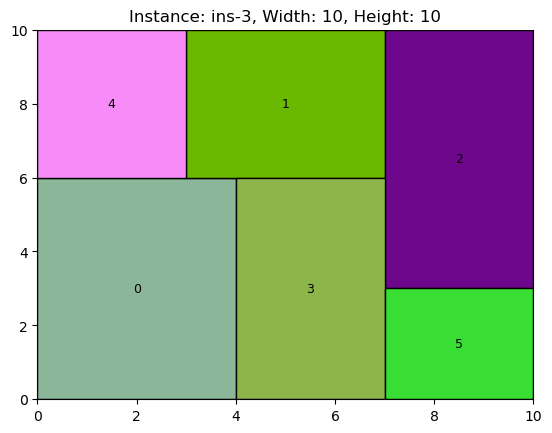

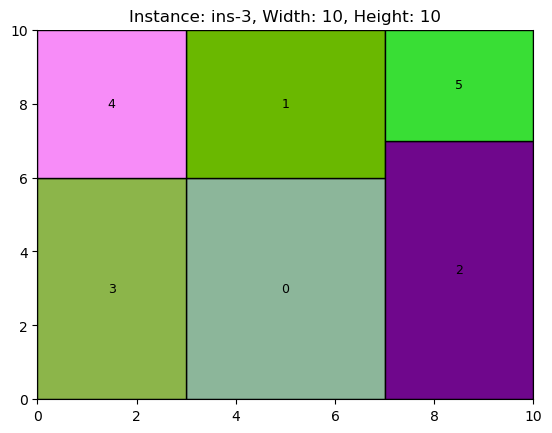

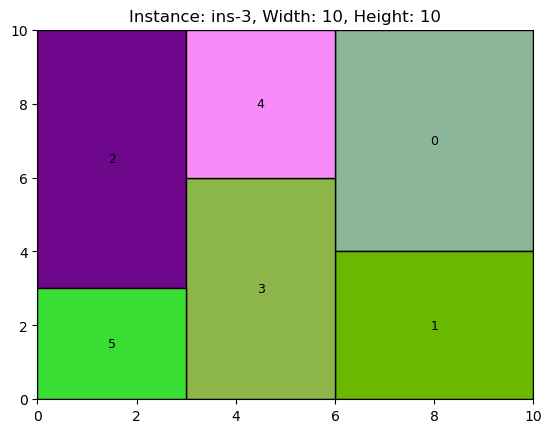

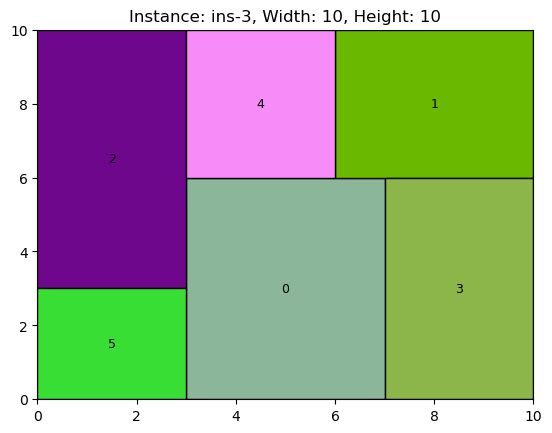

  8%|▊         | 3/40 [00:05<01:09,  1.88s/it]

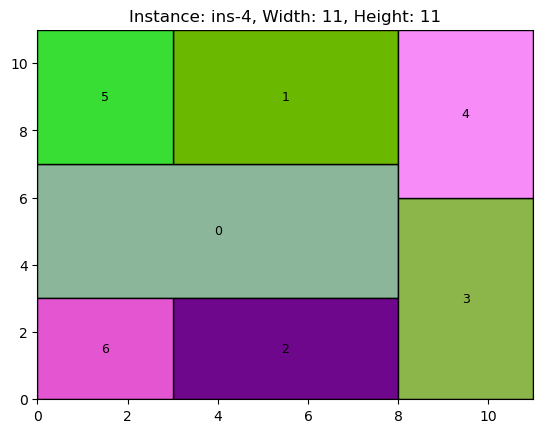

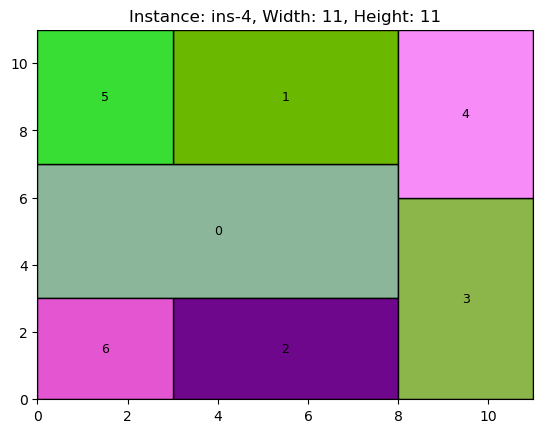

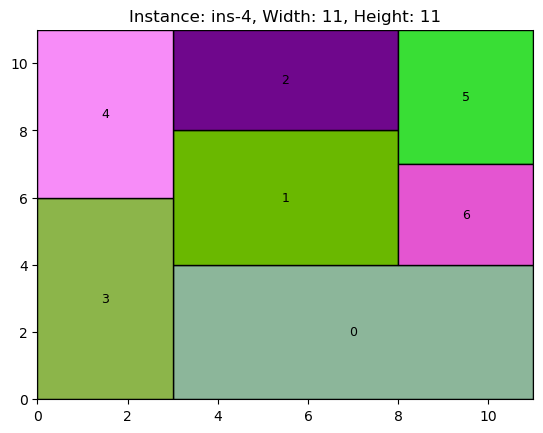

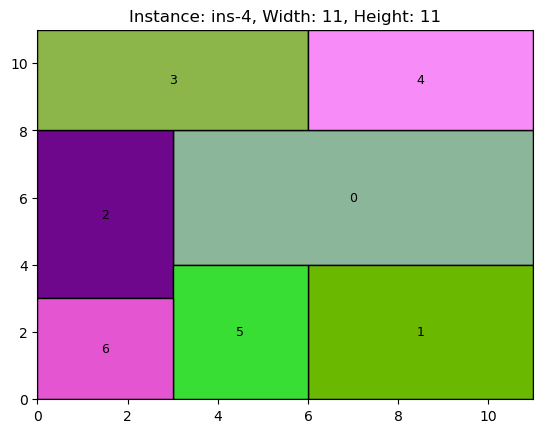

 10%|█         | 4/40 [00:07<01:07,  1.87s/it]

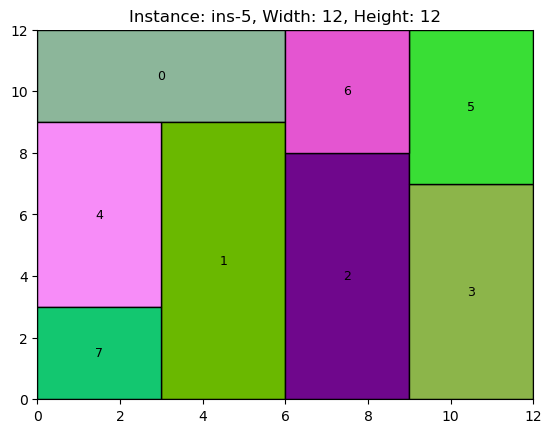

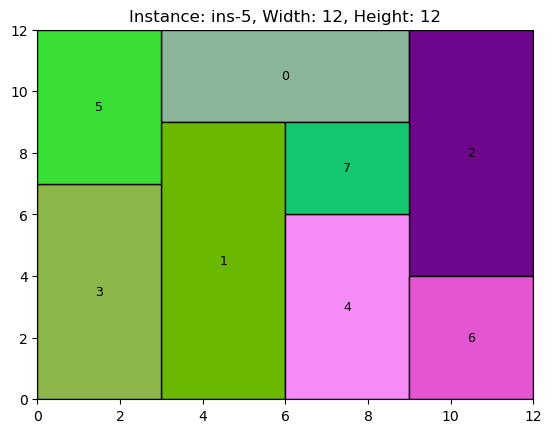

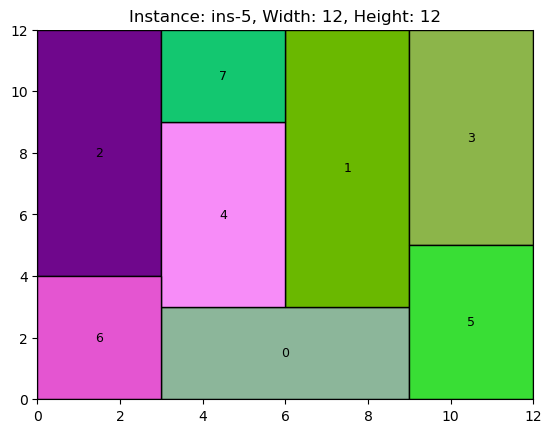

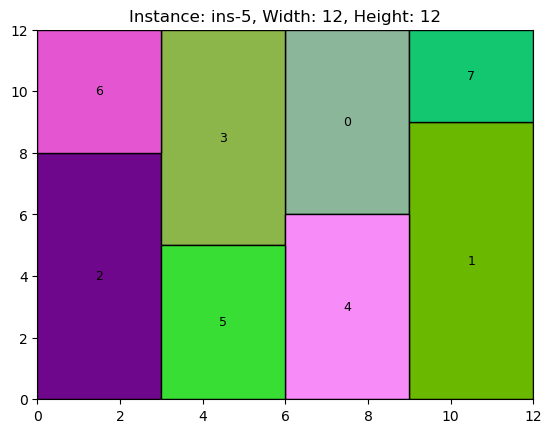

 12%|█▎        | 5/40 [00:10<01:19,  2.27s/it]

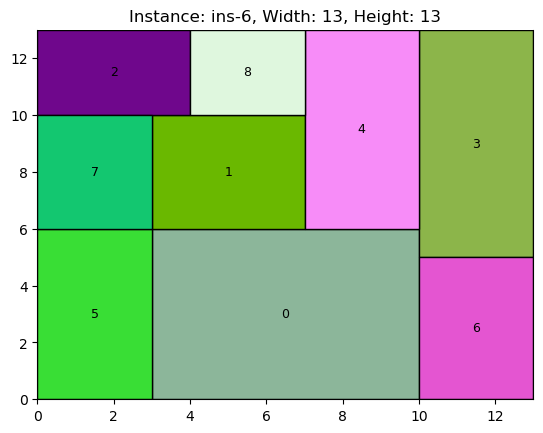

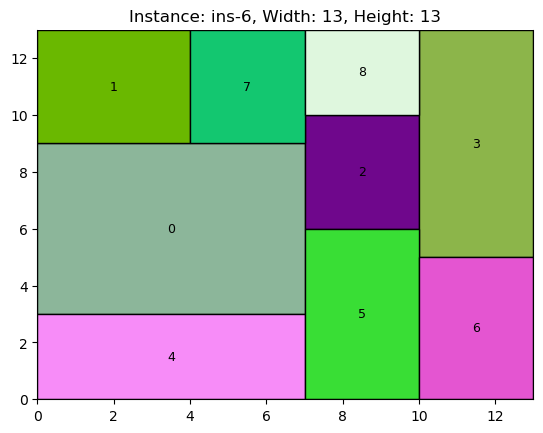

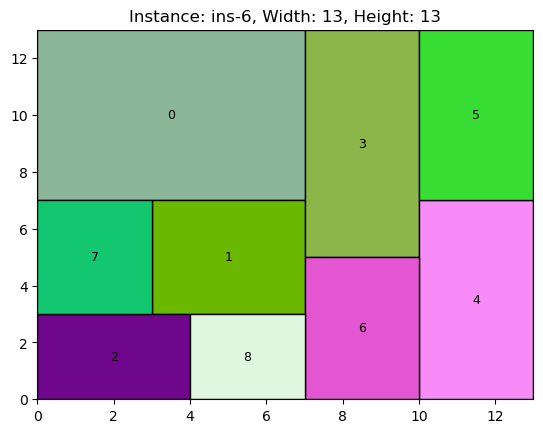

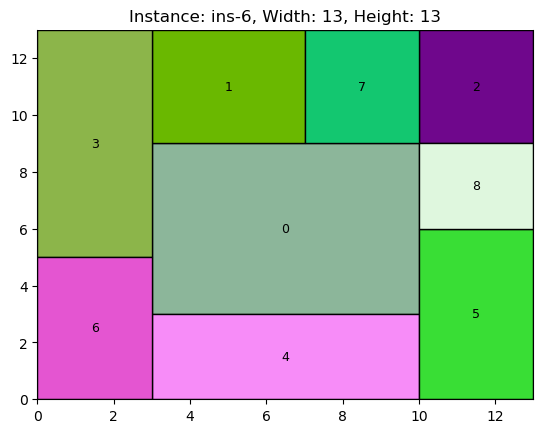

 15%|█▌        | 6/40 [00:14<01:33,  2.74s/it]

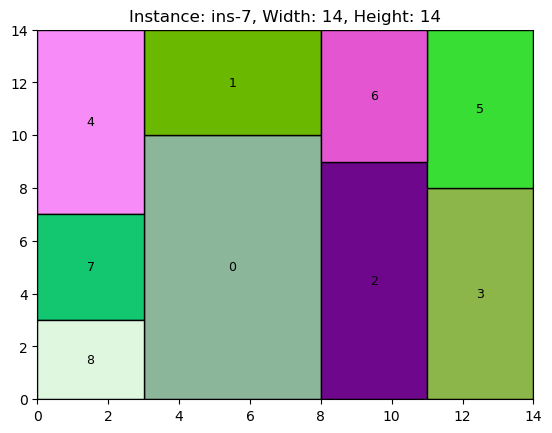

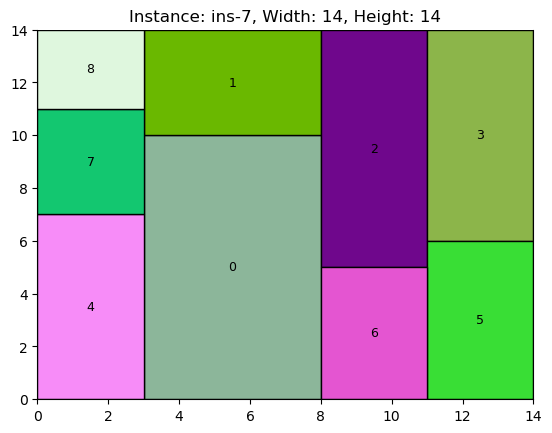

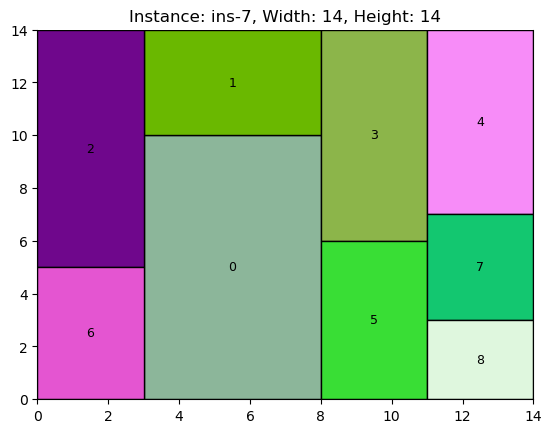

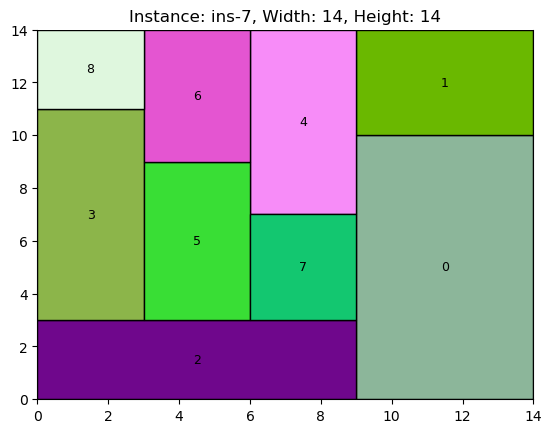

 18%|█▊        | 7/40 [00:17<01:38,  2.99s/it]

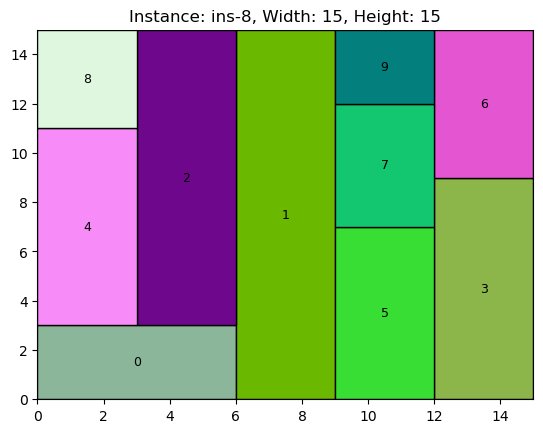

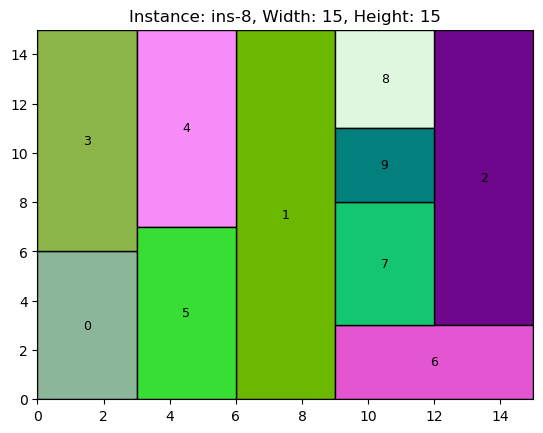

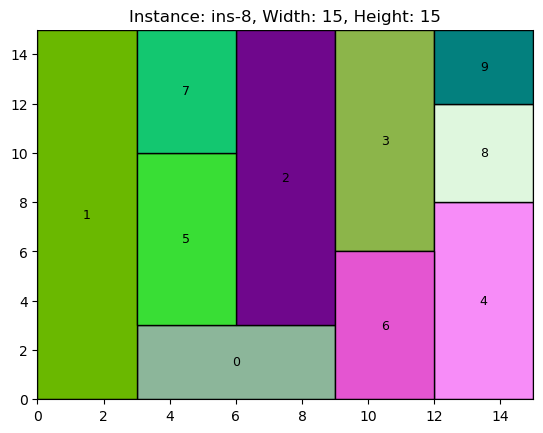

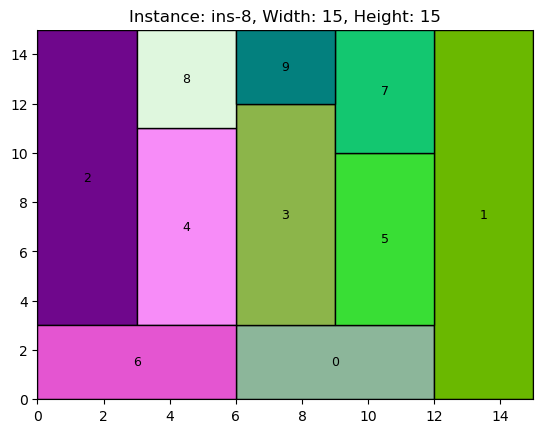

 20%|██        | 8/40 [00:20<01:36,  3.01s/it]

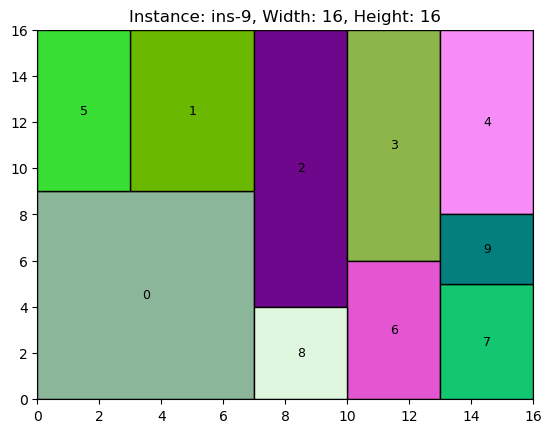

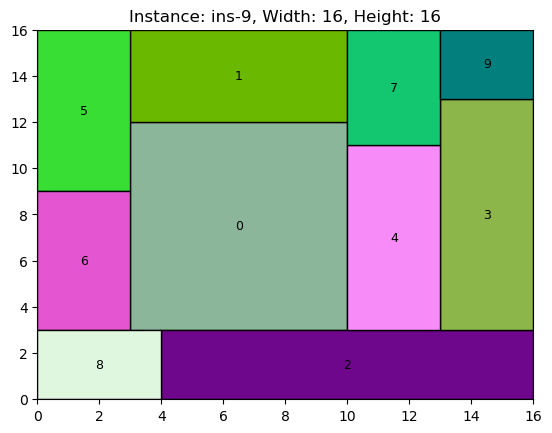

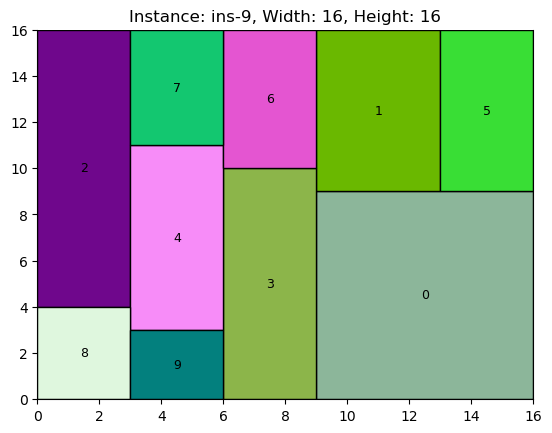

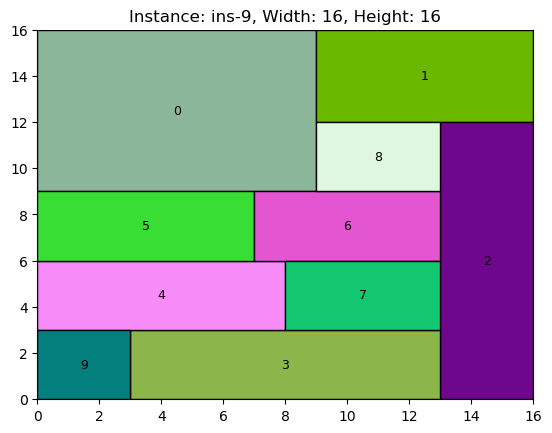

 22%|██▎       | 9/40 [00:24<01:39,  3.21s/it]

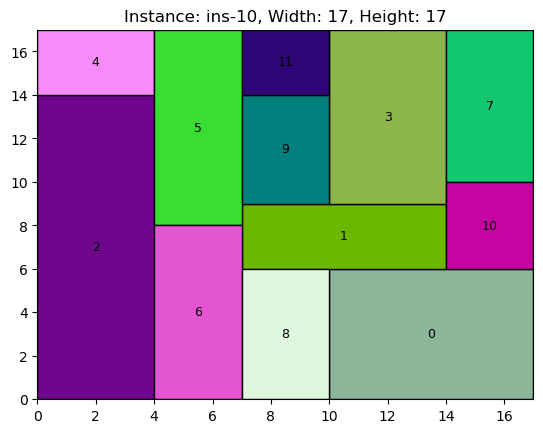

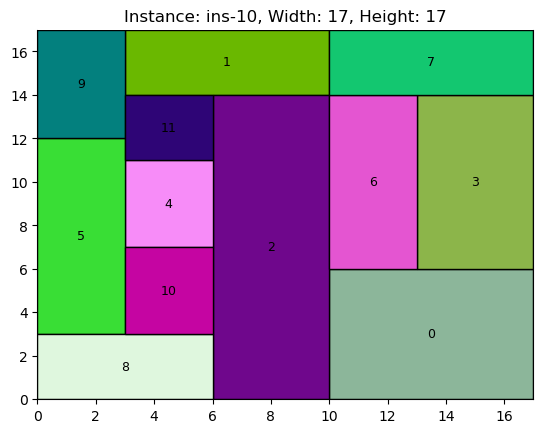

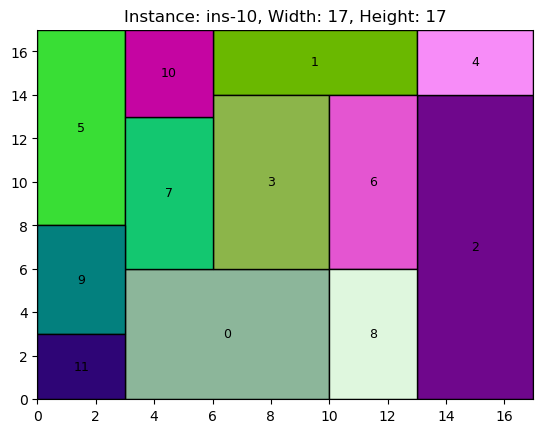

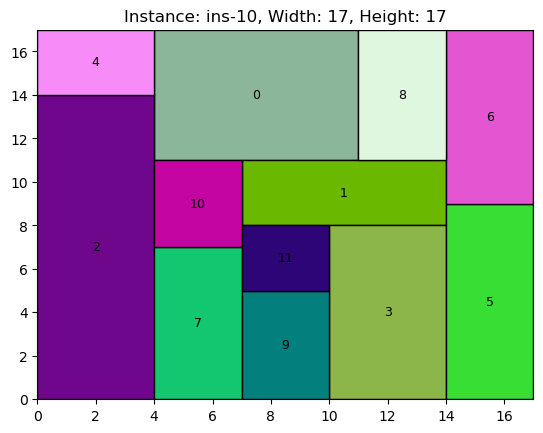

 25%|██▌       | 10/40 [00:32<02:17,  4.57s/it]

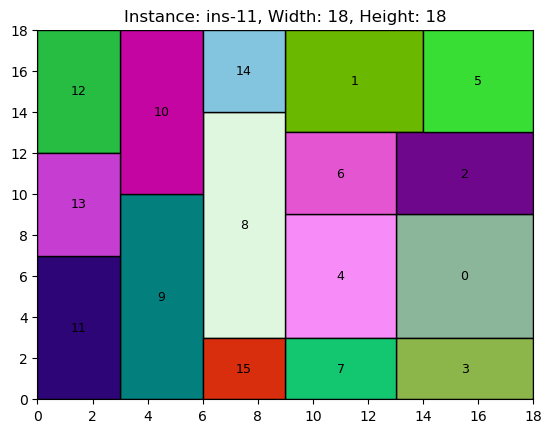

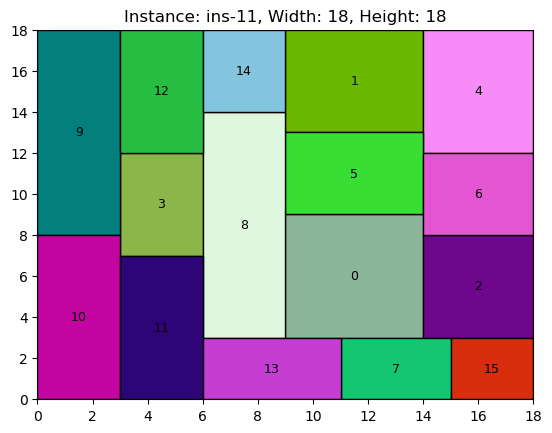

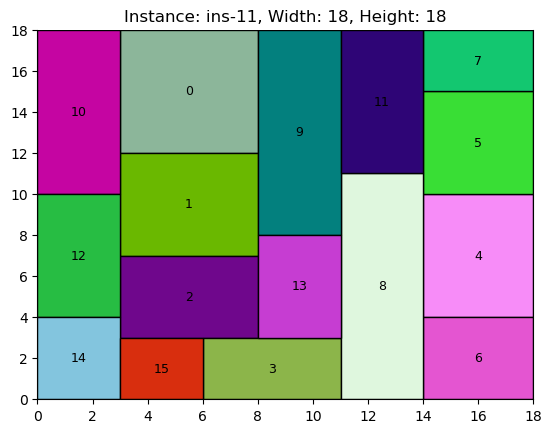

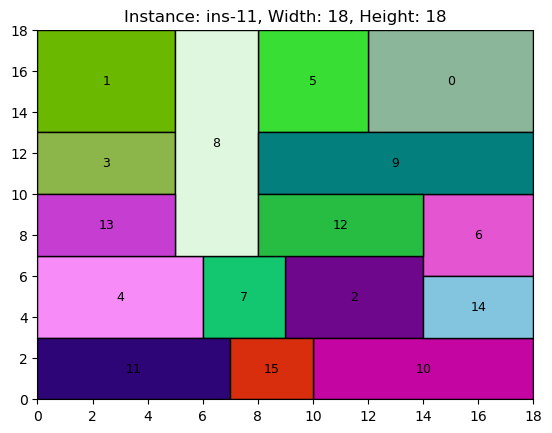

 28%|██▊       | 11/40 [02:51<22:06, 45.74s/it]

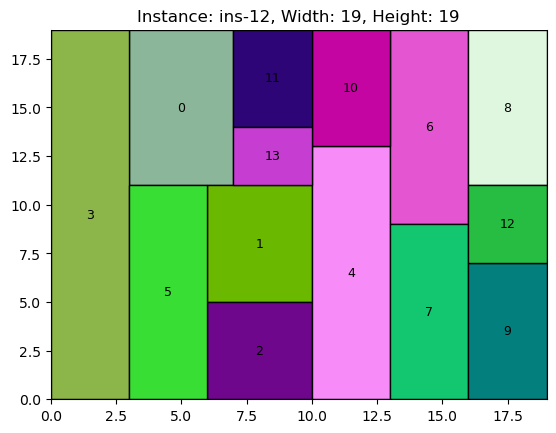

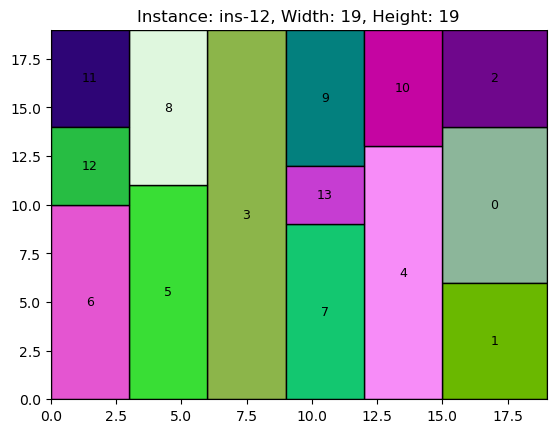

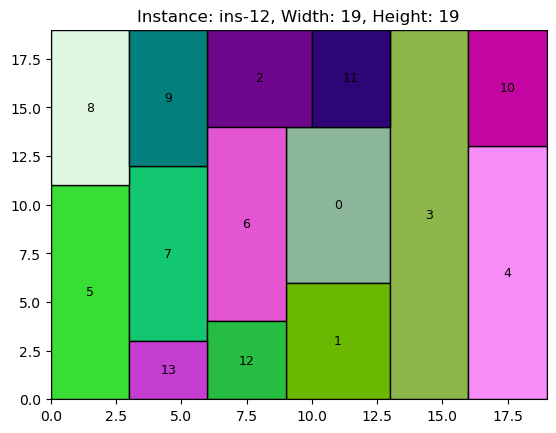

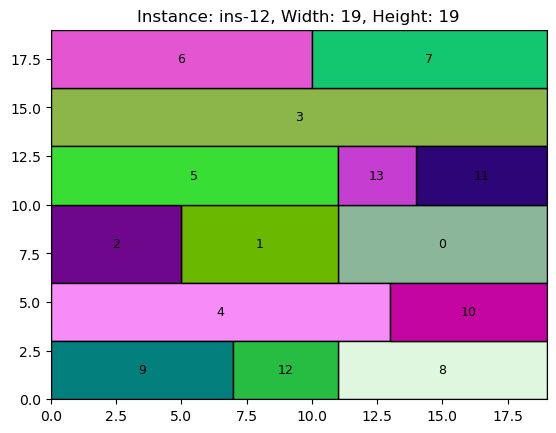

 30%|███       | 12/40 [03:02<16:29, 35.34s/it]

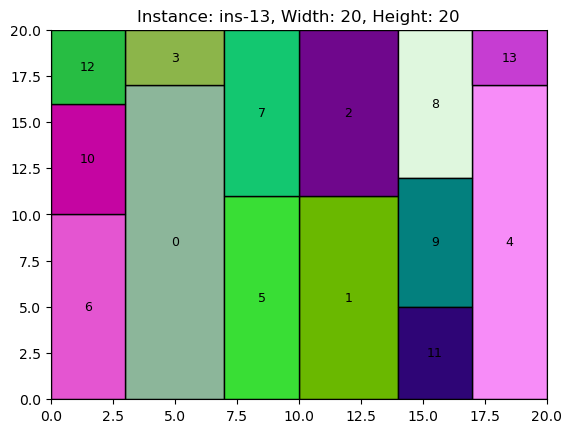

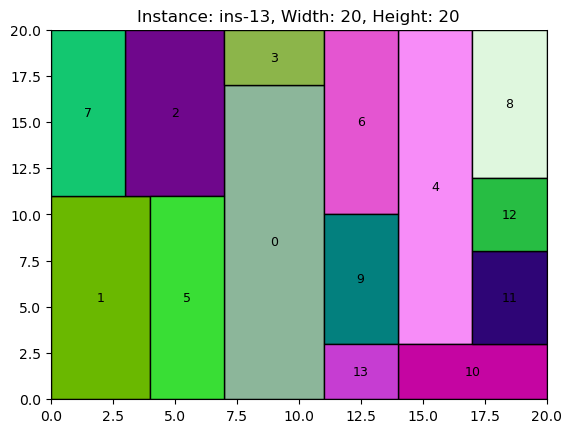

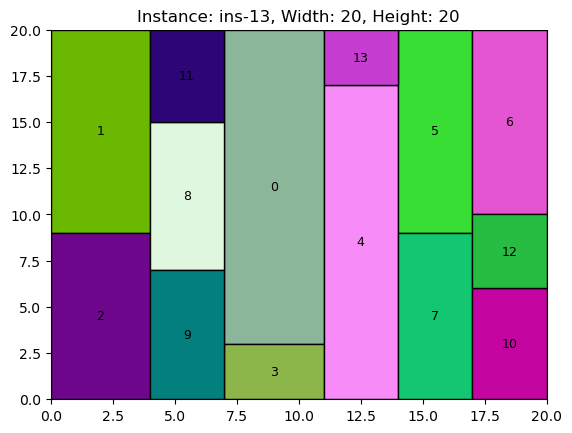

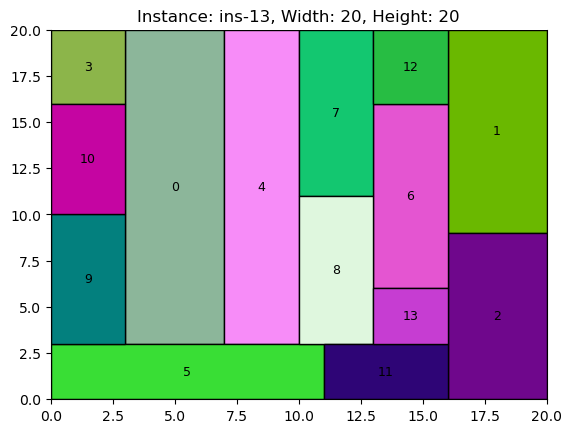

 32%|███▎      | 13/40 [03:22<13:44, 30.52s/it]

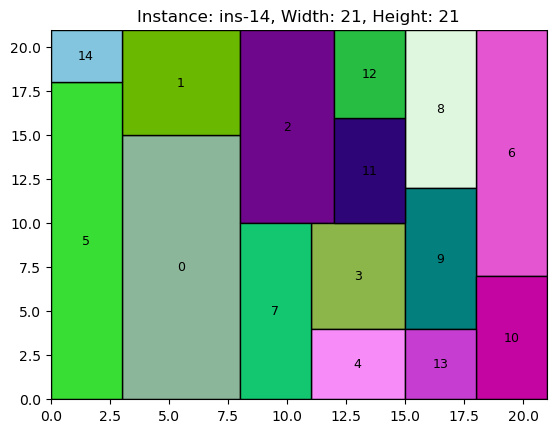

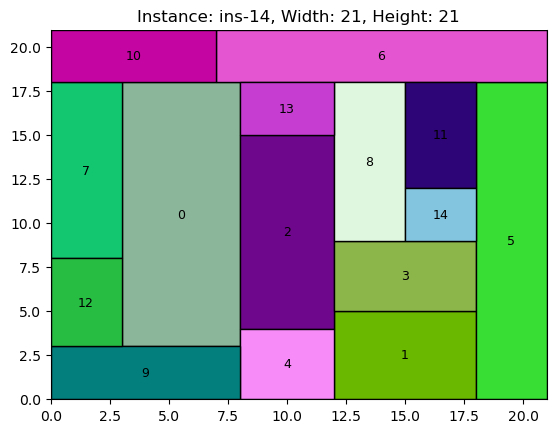

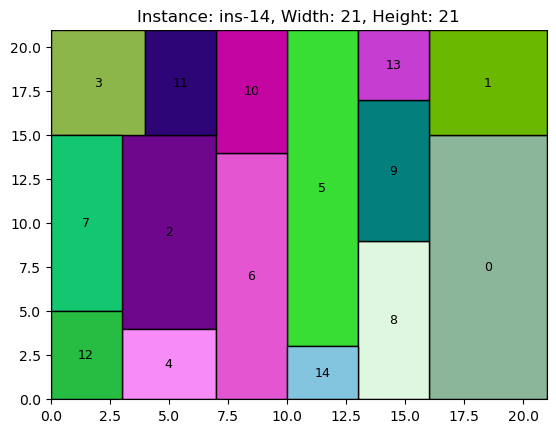

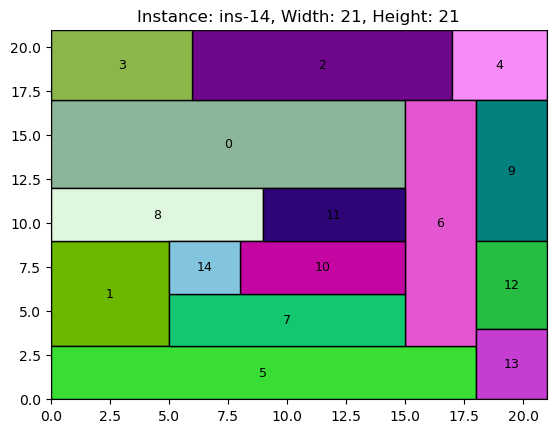

 35%|███▌      | 14/40 [03:58<13:55, 32.14s/it]

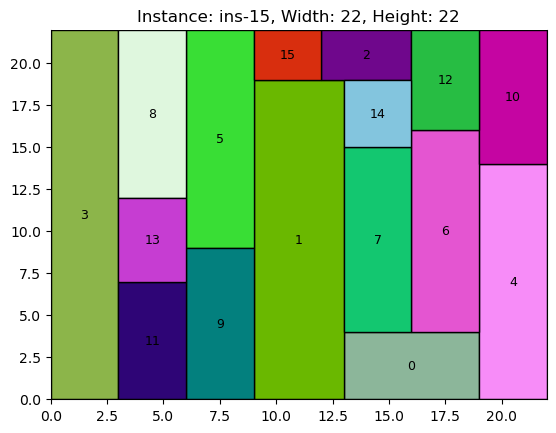

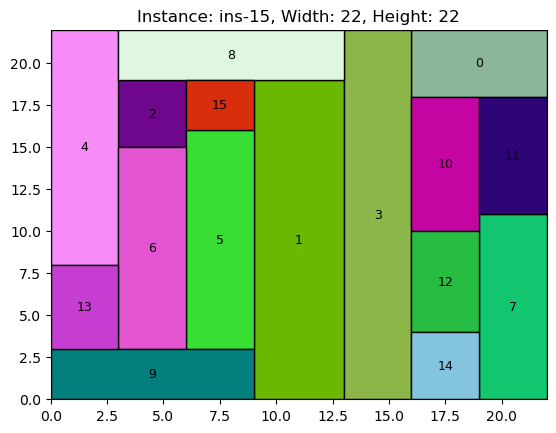

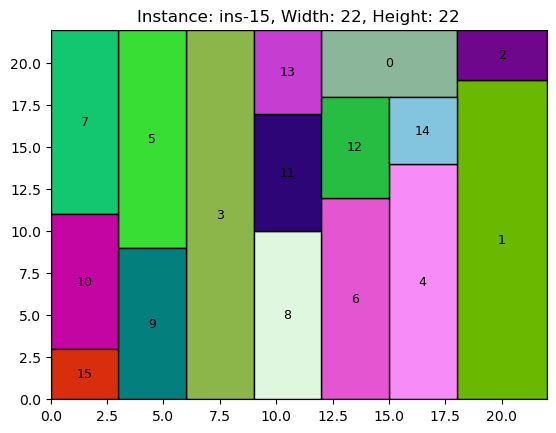

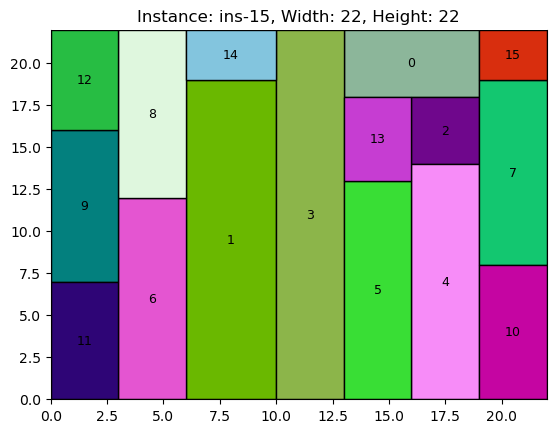

 38%|███▊      | 15/40 [05:10<18:23, 44.14s/it]

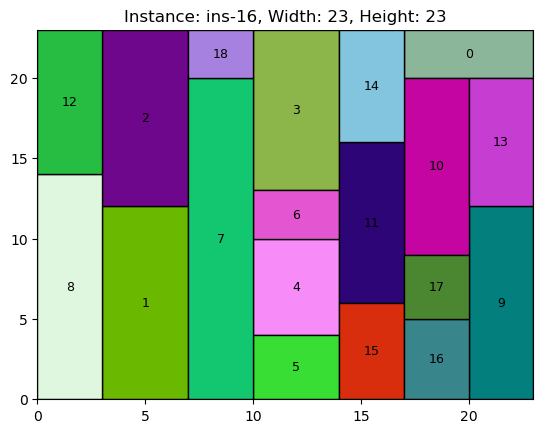

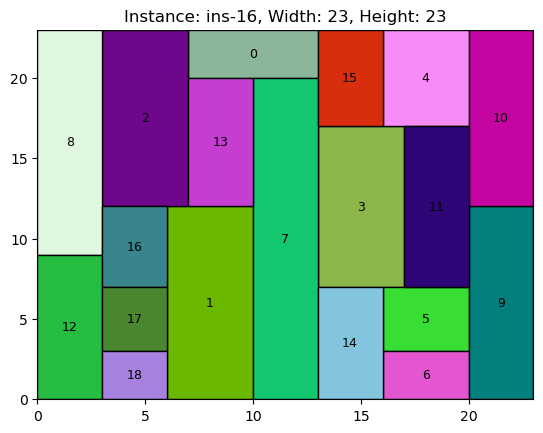

 38%|███▊      | 15/40 [11:43<19:32, 46.91s/it]


KeyboardInterrupt: 

In [5]:
import time
from tqdm import tqdm

def smt_benchmark(index, timeout, method, verbose = False, plot = False):
    
    if method == "base":
        rotations = False
        symmetry_breaking = False
    
    if method == "base-sb":
        rotations = False
        symmetry_breaking = True
    
    if method == "rotations":
        rotations = True
        symmetry_breaking = False
    
    if method == "rotations-sb":
        rotations = True
        symmetry_breaking = True
        
    folder = "../../instances/"
    file = f"ins-{index}.txt"
    url = folder + file
    instance = VLSI_Instance(path=url, order_by_width = True)
    widths, heights = instance.get_width_height()
    
    start = time.time()
    time_over, px, py, z3_time, rotated = pack_rectangles(timeout, instance.W, instance.H_LB(), instance.H_UB_BL(), instance.n_instances, widths, heights, rotations, symmetry_breaking, verbose)
    end = time.time()
    
    rectangles = instance.rectangles
    solve_time = (end - start)
    if not(time_over):
        for i in range(instance.n_instances):

            rectangles[i].x = px[i]
            rectangles[i].y = py[i]


            if rotations and rotated[i]:
                width = rectangles[i].width
                height = rectangles[i].height
                rectangles[i].height = width 
                rectangles[i].width = height
                rectangles[i].rotated = True

        instance.H = max([(rect.y + rect.height) for rect in rectangles])


        path = method


        if not(time_over):
            write_log(path="../../out/smt/" + path + "/" + file, instance = instance,
                      add_text="\n" + str(solve_time) + "\n" + str(time_over)+"\n"+ "OPTIMAL")

        if plot:
            plot_rectangles(rectangles, title=file, indexes=True)

    return solve_time, time_over, z3_time

def plot_SMT_benchmark(instances_to_solve = 5,timeout = 300, plot=False, verbose=False):
    '''
    Plotting the barplot with all the SMT solving mechanisms (base, rotated, 
    base + symmetry breaking, rotated + symmetry breaking)
    '''

    times_base = []
    times_base_rotate = []
    times_SB = []
    times_SB_rotate = []

    z3_times_base = []
    z3_times_base_rotate = []
    z3_times_SB = []
    z3_times_SB_rotate = []

    time_overs_base = []
    time_overs_base_rotate = []
    time_overs_SB = []
    time_overs_SB_rotate = []
    
    for i in tqdm(range(1, instances_to_solve + 1)):
        timer, time_over, z3_timer = smt_benchmark(i, timeout, "base-sb", verbose = verbose, plot = plot)
        times_SB.append(timer)
        z3_times_SB.append(z3_timer)

        if(time_over):
            time_overs_SB.append(i-1)


        timer, time_over, z3_timer =  smt_benchmark(i, timeout, "rotations-sb", verbose = verbose, plot = plot)
        times_SB_rotate.append(timer)
        z3_times_SB_rotate.append(z3_timer)

        if(time_over):
            time_overs_SB_rotate.append(i-1)

        url = f"../instances/ins-{i}.txt"
        timer, time_over, z3_timer = smt_benchmark(i, timeout, "base", verbose = verbose, plot = plot)
        times_base.append(timer)
        z3_times_base.append(z3_timer)

        if(time_over):
            time_overs_base.append(i-1)

        url = f"../instances/ins-{i}.txt"
        timer, time_over, z3_timer = smt_benchmark(i, timeout, "rotations", verbose = verbose, plot = plot)
        times_base_rotate.append(timer)
        z3_times_base_rotate.append(z3_timer)

        if(time_over):
            time_overs_base_rotate.append(i-1)

    X = range(1, instances_to_solve + 1) 
    X_axis = np.arange(0,len(times_SB)*2,2)
    plt.rcParams["figure.figsize"] = (13,6)
    plt.xticks(X_axis, X)

    # base z3
    barbase = plt.bar(X_axis - 0.6, z3_times_base, 0.4, label = 'Base z3 time')
  
    # base total
    #plt.plot(X_axis, times_base, linestyle='--', marker='o', label='Base total time')

    for i in time_overs_base:  
        barbase[i].set_alpha(0.25)
  
    # base + rotation z3
    barbaserotation = plt.bar(X_axis - 0.2, z3_times_base_rotate, 0.4, label = 'Rotated z3 time')
  
    # base + rotation total
   # plt.plot(X_axis, times_base_rotate, linestyle='--', marker='o', label='Rotated total time')

    for i in time_overs_base_rotate:
        barbaserotation[i].set_alpha(0.25)

    # SB
    barSB = plt.bar(X_axis + 0.2, z3_times_SB, 0.4, label = 'SB z3 time')
  
    # SB total
   # plt.plot(X_axis, times_SB, linestyle='--', marker='o', label='SB total time')

    for i in time_overs_SB:  
        barSB[i].set_alpha(0.25)
        
    # SB + rotation
    barSBrotation = plt.bar(X_axis + 0.6, z3_times_SB_rotate, 0.4, label = 'Rotated + SB z3 time')

    #SB + rotation total
    #plt.plot(X_axis, times_SB_rotate, linestyle='--', marker='o', label='Rotated + SB total time')

    for i in time_overs_SB_rotate:  
        barSBrotation[i].set_alpha(0.25)

    plt.xlabel("VLSI instance files")
    plt.ylabel("Time(s)")
    plt.title("VLSI SMT Benchmark")
    plt.grid()
    plt.axhline(y=timeout, xmin=0, xmax=1, color='r', linestyle='-.', linewidth=2, label=f"time_limit = {timeout} s")
    #plt.yscale("log")
    plt.legend()
    plt.savefig('../../out/smt/smt_benchmark.png', transparent=False,format="png")
    plt.show()

    out_text= ""
    
    out_text += f"total Base time        -- mean: {np.mean(times_base)} std: {np.std(times_base)} \n"
    out_text += f"total rotated time     -- mean: {np.mean(times_base_rotate)} std: {np.std(times_base_rotate)} \n"
    out_text += f"total SB time          -- mean: {np.mean(times_SB)} std: {np.std(times_SB)} \n"
    out_text += f"total rotated + SB time-- mean: {np.mean(times_SB_rotate)} std: {np.std(times_SB_rotate)} \n"
    
    out_text += f"z3 Base time           -- mean: {np.mean(z3_times_base)} std: {np.std(z3_times_base)} \n"
    out_text += f"z3 rotated time        -- mean: {np.mean(z3_times_base_rotate)} std: {np.std(z3_times_base_rotate)} \n"
    out_text += f"z3 SB time             -- mean: {np.mean(z3_times_SB)} std: {np.std(z3_times_SB)} \n"
    out_text += f"z3 rotated + SB time   -- mean: {np.mean(z3_times_SB_rotate)} std: {np.std(z3_times_SB_rotate)}"

 # write txt log
    with  open("../../out/smt/smt_benchmark_log.txt","w") as file:
        content = out_text
        file.writelines(content)
        file.close()
        
    print(out_text)
    
#timeout is set in seconds
plot_SMT_benchmark(instances_to_solve=40, timeout=300, plot=True)